# Clustering using Hidden Markov Model 

### Import packages

In [1]:
import mne
import numpy as np
import pandas as pd
import seaborn as sns
from hmmlearn import hmm
from simpl_eeg import (
    connectivity,
    eeg_objects,
    raw_voltage,
    topomap_2d,
    topomap_3d_brain,
    topomap_3d_head,
)
import matplotlib.pyplot as plt


In [2]:
%matplotlib inline

### Read in the data

In [3]:
raw_full = mne.io.read_raw_eeglab("../../data/927/fixica.set")

Reading C:\Users\Yiki\Documents\UBC\MDS\Homework\capstone\simpl_eeg_capstone\data\927\fixica.fdt


<ipython-input-3-99b5e4cf8c83>:1: RuntimeWarning: Data file name in EEG.data (927 fix ica correct.fdt) is incorrect, the file name must have changed on disk, using the correct file name (fixica.fdt).
  raw_full = mne.io.read_raw_eeglab("../../data/927/fixica.set")


In [4]:
entire_df = raw_full.to_data_frame()

In [5]:
channel_names=raw_full.ch_names

### EDA

<AxesSubplot:>

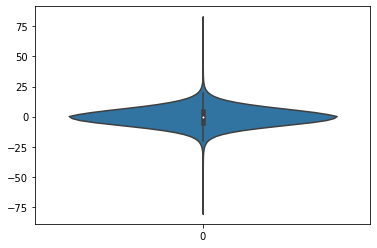

In [7]:
sns.violinplot(data=entire_df.loc[:,"Fp1"])

<AxesSubplot:>

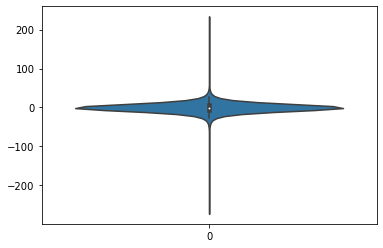

In [6]:
sns.violinplot(data=entire_df.loc[:,channel_names[2]])

<AxesSubplot:>

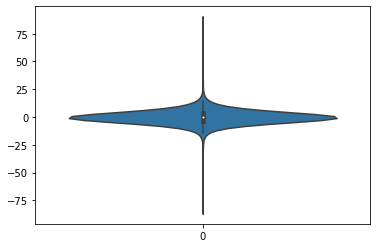

In [7]:
sns.violinplot(data=entire_df.loc[:,channel_names[3]])

<AxesSubplot:>

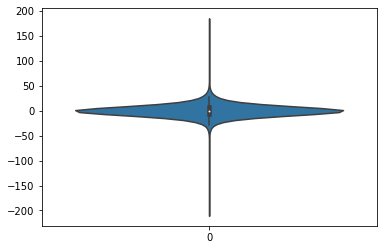

In [8]:
sns.violinplot(data=entire_df.loc[:,channel_names[4]])

### Data preprocessing

In [6]:
# to get average chunked data

cleaned_df = entire_df.loc[(entire_df[channel_names] != 0).all(axis=1)] # drop rows where all values are zero

df_no_outliers = cleaned_df.loc[((cleaned_df[channel_names] <=50) & (cleaned_df[channel_names] >= -50)).all(axis=1)].groupby("time").mean().reset_index()

sliced_col = int((len(df_no_outliers))/(2048*5))

avg_chunked_list = []
for i in range(sliced_col):
    avg_sliced_array = (
        df_no_outliers.iloc[i * 10240 : i * 10240 + 10240, 1:].mean().to_numpy()
    )  # separate the data into chunks of per 5 seconds and get the average
    avg_chunked_list.append(avg_sliced_array)
avg_chunked_array = np.array(avg_chunked_list)

In [ ]:
# round(df_no_outliers.describe(), 3)

In [ ]:
# to get chunk data, not used since file is too large and the operation runs out of memory

# avg_df = entire_df.groupby("time").mean().reset_index()
# entire_list = []
# for i in range(541):
#     sliced_array = avg_df.iloc[i*10000:i*10000+10000, 1:].to_numpy().reshape(-1)
#     entire_list.append(sliced_array)
# entire_array_chunk = np.array(entire_list)

# entire_array_chunk=np.float32(entire_array_chunk)

## Remove outliers

In [ ]:
centered_model = hmm.GaussianHMM(n_components=4)

In [ ]:
centered_model.fit(avg_chunked_array)

In [ ]:
centered_result = centered_model.decode(avg_chunked_array, algorithm="viterbi")

In [ ]:
result_on_outlier = df_no_outliers.copy()
for index, labels in enumerate(centered_result[1]):
    result_on_outlier.loc[index * 10240 : index * 10240 + 10240, "cluster"] = labels

In [ ]:
result_df_outlier=result_on_outlier.dropna()

In [ ]:
pca_no_outlier=plot_pca_clusters(result_df_outlier.iloc[:, 1:20], result_df_outlier.cluster)

In [ ]:
df_sub_no_outlier = {}
for i in range(19):
    df_sub_no_outlier[i] = result_df_outlier[result_df_outlier['cluster'] == i].iloc[:, 1:20]

In [ ]:
fig_no_outlier, axes_no_outlier = plt.subplots(nrows=4, ncols=1, figsize=(90, 90))
fig_no_outlier.suptitle('4 Clusters with no outliers')

for i, ax in enumerate(axes_no_outlier.flatten()):
    sns.violinplot(x="node", y="eeg", data=df_sub_no_outlier[i].melt(var_name="node", value_name="eeg"), ax=ax)

fig_no_outlier.show()

### Hyperparameter tuning

In [ ]:
tune_comp = {}
model_list = []
for n_comp in range(5, 21, 1):
    model = hmm.GaussianHMM(n_components=n_comp)
    model_list.append(model)
    model.fit(avg_chunked_array)
    result = model.decode(avg_chunked_array, algorithm="viterbi")
    tune_comp[n_comp] = result[0]

In [ ]:
maximum = max(tune_comp, key=tune_comp.get)
print(
    f"The best # of cluster is {maximum}, with log probability of {tune_comp[maximum]}"
)

### Model fitting

In [ ]:
model19 = model_list[14]
model19

In [ ]:
result19 = model19.decode(avg_chunked_array, algorithm="viterbi")

In [ ]:
result_df19 = sliced_df.copy()
for index, labels in enumerate(result19[1]):
    result_df19.loc[index * 10000 : index * 10000 + 10000, "cluster"] = labels

In [ ]:
model20 = model_list[-1]
model20

In [ ]:
result20 = model20.decode(avg_chunked_array, algorithm="viterbi")

In [ ]:
result_df20 = sliced_df.copy()
for index, labels in enumerate(result20[1]):
    result_df20.loc[index * 10000 : index * 10000 + 10000, "cluster"] = labels

### PCA 

In [ ]:
pca19=plot_pca_clusters(result_df19.iloc[:, 1:20], result_df19.cluster)
pca20=plot_pca_clusters(result_df20.iloc[:, 1:20], result_df20.cluster)

### Correlation

In [ ]:
df_corr19 = {}
for i in range(19):
    df_corr19[i] = result_df19[result_df19['cluster'] == i].iloc[:, 1:20].corr()

In [ ]:
df_corr20 = {}
for i in range(20):
    df_corr20[i] = result_df20[result_df20['cluster'] == i].iloc[:, 1:20].corr()

In [ ]:
# Set figsize here
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(30, 30))

for i, ax in enumerate(axes.flatten()[:19]):
    sns.heatmap(df_corr19[i], ax=ax)

fig.show()

In [ ]:
fig1, axes1 = plt.subplots(nrows=7, ncols=3, figsize=(30, 30))
fig1.suptitle('20 Clusters')

for i, ax in enumerate(axes1.flatten()[:20]):
    sns.heatmap(df_corr20[i], ax=ax)

fig1.show()

### Violin plot

In [ ]:
df_sub19 = {}
for i in range(19):
    df_sub19[i] = result_df19[result_df19['cluster'] == i].iloc[:, 1:20]

In [ ]:
df_sub20 = {}
for i in range(20):
    df_sub20[i] = result_df20[result_df20['cluster'] == i].iloc[:, 1:20]

In [ ]:
%matplotlib inline

In [ ]:
fig2, axes2 = plt.subplots(nrows=19, ncols=1, figsize=(90, 90))
fig2.suptitle('19 Clusters')

for i, ax in enumerate(axes2.flatten()[:19]):
    sns.violinplot(x="node", y="eeg", data=df_sub19[i].melt(var_name="node", value_name="eeg"), ax=ax)

fig2.show()

In [ ]:
fig3, axes3 = plt.subplots(nrows=20, ncols=1, figsize=(90, 90))
fig3.suptitle('20 Clusters')

for i, ax in enumerate(axes3.flatten()[:20]):
    sns.violinplot(x="node", y="eeg", data=df_sub20[i].melt(var_name="node", value_name="eeg"), ax=ax)
fig3.show()

## Try less clusters

In [ ]:
model4 = hmm.GaussianHMM(n_components=4)
model4.fit(avg_chunked_array)

In [ ]:
result4 = model4.decode(avg_chunked_array, algorithm="viterbi")

In [ ]:
result_df4 = sliced_df.copy()
for index, labels in enumerate(result4[1]):
    result_df4.loc[index * 10000 : index * 10000 + 10000, "cluster"] = labels

In [ ]:
pca4=plot_pca_clusters(result_df4.iloc[:, 1:20], result_df4.cluster)
pca4

In [ ]:
df_corr4 = {}
for i in range(4):
    df_corr4[i] = result_df4[result_df4['cluster'] == i].iloc[:, 1:20].corr()

In [ ]:
fig6, axes6 = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
fig6.suptitle('4 Clusters')

for i, ax in enumerate(axes6.flatten()):
    sns.heatmap(df_corr4[i], ax=ax)

fig6.show()

In [ ]:
df_sub4 = {}
for i in range(4):
    df_sub4[i] = result_df4[result_df4['cluster'] == i].iloc[:, 1:20]

In [ ]:
fig7, axes7 = plt.subplots(nrows=4, ncols=1, figsize=(90, 90))
fig7.suptitle('4 Clusters')

for i, ax in enumerate(axes7.flatten()):
    sns.violinplot(x="node", y="eeg", data=df_sub4[i].melt(var_name="node", value_name="eeg"), ax=ax)
fig7.show()

In [ ]:
model10 = hmm.GaussianHMM(n_components=10)

In [ ]:
model10.fit(avg_chunked_array)

In [ ]:
result10 = model10.decode(avg_chunked_array, algorithm="viterbi")

In [ ]:
result_df10 = sliced_df.copy()
for index, labels in enumerate(result10[1]):
    result_df10.loc[index * 10000 : index * 10000 + 10000, "cluster"] = labels

In [ ]:
pca10=plot_pca_clusters(result_df10.iloc[:, 1:20], result_df10.cluster)
pca10

In [ ]:
df_corr10 = {}
for i in range(10):
    df_corr10[i] = result_df10[result_df10['cluster'] == i].iloc[:, 1:20].corr()

In [ ]:
fig4, axes4 = plt.subplots(nrows=4, ncols=3, figsize=(30, 30))
fig4.suptitle('10 Clusters')

for i, ax in enumerate(axes4.flatten()[:10]):
    sns.heatmap(df_corr10[i], ax=ax)

fig4.show()

In [ ]:
df_sub10 = {}
for i in range(10):
    df_sub10[i] = result_df10[result_df10['cluster'] == i].iloc[:, 1:20]

In [ ]:
fig5, axes5 = plt.subplots(nrows=10, ncols=1, figsize=(90, 90))
fig5.suptitle('10 Clusters')

for i, ax in enumerate(axes5.flatten()[:10]):
    sns.violinplot(x="node", y="eeg", data=df_sub10[i].melt(var_name="node", value_name="eeg"), ax=ax)
fig5.show()